In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import time
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [4]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False, directory = '/home/wolfman/Pictures', return_P=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_ind=[]
    params['u_sol']=u
    #params['ux']=ux
    #params['uy']=uy
    refined=[]
    P=[]
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            fig = plt.figure()
            MP.mesh.draw(fig=fig)
            plt.axis('off')
            plt.axis('scaled');
            plt.savefig(directory + '/i'+str(i)+'.png',bbox_inches='tight')
            plt.close(fig)
            #plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if i < maxiter-1:
            start=time.time()
            err_ind.append(adap.PoissonEstimator(MP,uh,f))
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_marking(err_ind[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            P.append(MP.patch_refine(h_ref=marked_patches, return_P=True))
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_ind, refined, P

In [5]:
def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for i in range(maxiter):
        print(i)
        if draw:
            MP.mesh.draw(bwidth=1)
            plt.axis('scaled');
            plt.show()
            
        numdofs[i] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        #Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f[0])
        
        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))
        
        if u:
            Mh = MP.assemble_volume(vform.mass_vf(2))
            u_rhs = MP.assemble_volume(vform.L2functional_vf(2, physical=True),f=u)
            u_ = (cholesky(Mh.tocsc()))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[i] = sqrt(eh.T@Mh@eh)
            H1err[i] = sqrt(eh.T@Kh@eh + L2err[i]**2)
            
        if i < maxiter-1:
            start=time.time()
            MP.patch_refine(h_ref=-1)
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    #MP.plot(uh)
        
    return MP, uh, numdofs, L2err, H1err

In [7]:
for deg, maxiter in zip((4,),(8,)):
    M = Lshape(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    uh=[]
    numdofs = np.zeros(maxiter,dtype=float)
    P=[]
    return_P = True

    for i in range(maxiter):
        print(i)
        bcs = MP.compute_dirichlet_bcs({0:0.})
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        Mh = MP.assemble_volume(vform.mass_vf(2))
        F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        numdofs[i] = MP.numdofs
        print(MP.numdofs)

        if i < maxiter-2 :
            P.append(MP.h_refine(h_ref=-1, return_P=return_P))
        elif i == maxiter-2:
            P.append(MP.p_refine(p_inc=1, return_P=return_P))
        else:
            pass

    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    L2err = np.zeros(maxiter)
    H1err = np.zeros(maxiter)
    for i in range(len(uh)-1):
        eh = P[i]@uh[i]-uh[-1]
        L2err[i] = eh @ Mh @ eh
        H1err[i] = eh @ Kh @ eh + L2err[-1]
    L2err = sqrt(np.array(L2err))
    H1err = sqrt(np.array(H1err))
    np.savetxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'corner_uni.txt',np.c_[[numdofs,H1err,L2err]])

setting up constraints took 0.005160808563232422 seconds.
Basis setup took 0.005504608154296875 seconds
0
225
Refinement took 0.00015878677368164062 seconds for 3 patches.
setting up constraints took 0.003966093063354492 seconds.
Basis setup took 0.004094123840332031 seconds
Prolongation took 0.0060405731201171875 seconds
1
560
Refinement took 0.00013446807861328125 seconds for 3 patches.
setting up constraints took 0.0046312808990478516 seconds.
Basis setup took 0.005074262619018555 seconds
Prolongation took 0.006791830062866211 seconds
2
1680
Refinement took 0.0002117156982421875 seconds for 3 patches.
setting up constraints took 0.009619951248168945 seconds.
Basis setup took 0.008794069290161133 seconds
Prolongation took 0.013222932815551758 seconds
3
5720
Refinement took 0.0005884170532226562 seconds for 3 patches.
setting up constraints took 0.015095233917236328 seconds.
Basis setup took 0.013985395431518555 seconds
Prolongation took 0.023880958557128906 seconds
4
21000
Refinement

setting up constraints took 0.004238128662109375 seconds.
Basis setup took 0.00470733642578125 seconds
0


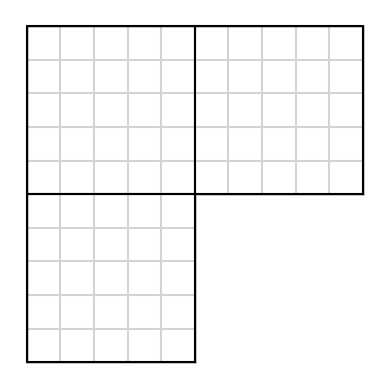

/tmp/ipykernel_51889/3425492297.py:24: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh_a.append(LS.complete((cholesky(LS.A))(LS.b)))


Residual contributions took 0.02296614646911621 seconds.
Jump contributions took 0.010273933410644531 seconds.
Refinement took 0.008556127548217773 seconds for 3 patches.
setting up constraints took 0.028057336807250977 seconds.
Basis setup took 0.00932455062866211 seconds
Prolongation took 0.022125720977783203 seconds
1


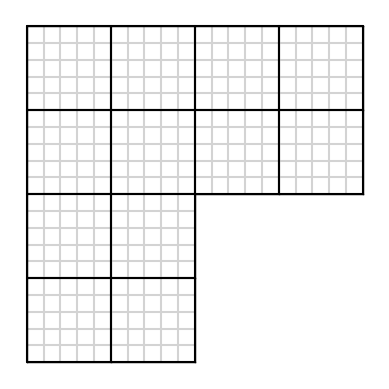

Residual contributions took 0.07776546478271484 seconds.
Jump contributions took 0.09175467491149902 seconds.
Refinement took 0.010599136352539062 seconds for 3 patches.
setting up constraints took 0.06306099891662598 seconds.
Basis setup took 0.00980520248413086 seconds
Prolongation took 0.022272348403930664 seconds
2


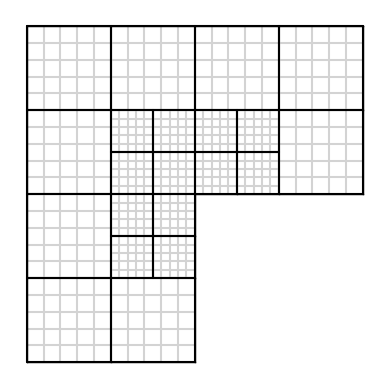

Residual contributions took 0.13037872314453125 seconds.
Jump contributions took 0.19232583045959473 seconds.
Refinement took 0.013467788696289062 seconds for 3 patches.
setting up constraints took 0.09723234176635742 seconds.
Basis setup took 0.014702320098876953 seconds
Prolongation took 0.02235269546508789 seconds
3


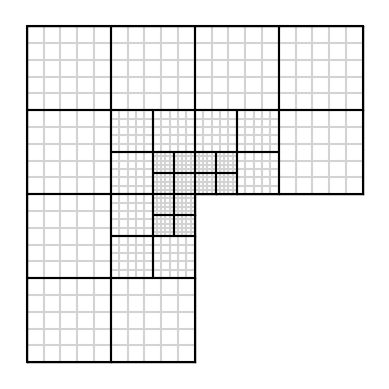

Residual contributions took 0.18412208557128906 seconds.
Jump contributions took 0.33050036430358887 seconds.
Refinement took 0.014463186264038086 seconds for 3 patches.
setting up constraints took 0.13374900817871094 seconds.
Basis setup took 0.018030881881713867 seconds
Prolongation took 0.022507429122924805 seconds
4


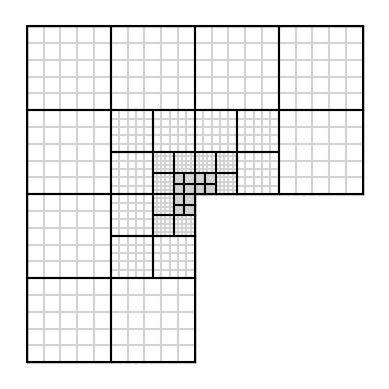

Residual contributions took 0.23843932151794434 seconds.
Jump contributions took 0.47301220893859863 seconds.
Refinement took 0.016360759735107422 seconds for 3 patches.
setting up constraints took 0.16983318328857422 seconds.
Basis setup took 0.021856307983398438 seconds
Prolongation took 0.02268362045288086 seconds
5


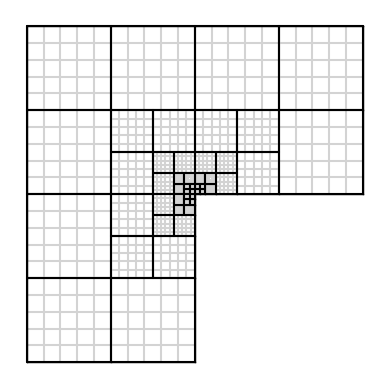

Residual contributions took 0.37096142768859863 seconds.
Jump contributions took 0.5489711761474609 seconds.
Refinement took 0.01811957359313965 seconds for 3 patches.
setting up constraints took 0.20854783058166504 seconds.
Basis setup took 0.025467872619628906 seconds
Prolongation took 0.022511005401611328 seconds
6


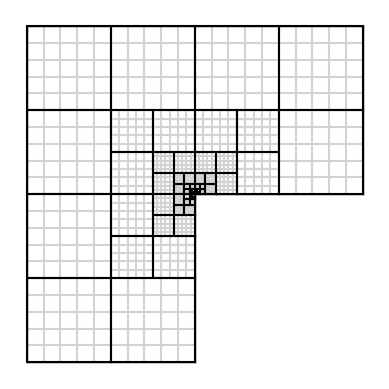

Residual contributions took 0.4136688709259033 seconds.
Jump contributions took 0.6591579914093018 seconds.
Refinement took 0.019830703735351562 seconds for 3 patches.
setting up constraints took 0.24289608001708984 seconds.
Basis setup took 0.030716896057128906 seconds
Prolongation took 0.022580623626708984 seconds
7


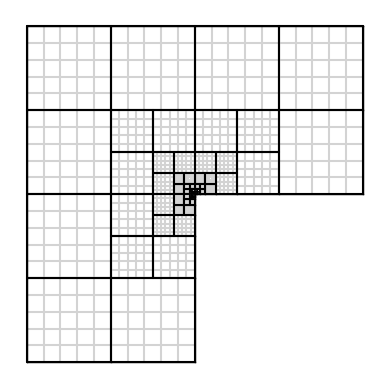

Residual contributions took 0.3960280418395996 seconds.
Jump contributions took 0.8292829990386963 seconds.
Refinement took 0.06502842903137207 seconds for 8 patches.
setting up constraints took 0.3295021057128906 seconds.
Basis setup took 0.03810930252075195 seconds
Prolongation took 0.05827951431274414 seconds
8


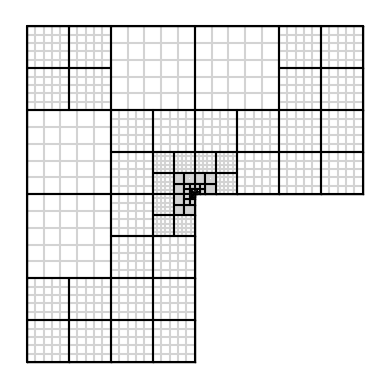

Residual contributions took 0.538198709487915 seconds.
Jump contributions took 1.0518560409545898 seconds.
Refinement took 0.027598857879638672 seconds for 3 patches.
setting up constraints took 0.3643686771392822 seconds.
Basis setup took 0.042456626892089844 seconds
Prolongation took 0.022472381591796875 seconds
9


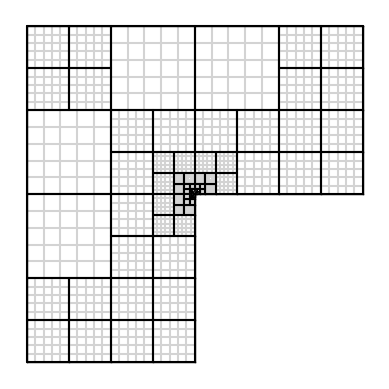

Residual contributions took 0.5943617820739746 seconds.
Jump contributions took 1.1759819984436035 seconds.
Refinement took 0.02858281135559082 seconds for 3 patches.
setting up constraints took 0.40314316749572754 seconds.
Basis setup took 0.054494619369506836 seconds
Prolongation took 0.02386760711669922 seconds
10


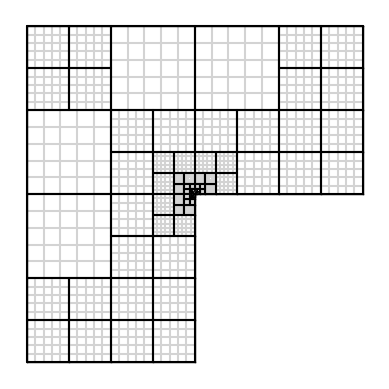

Residual contributions took 0.656442403793335 seconds.
Jump contributions took 1.2348690032958984 seconds.
Refinement took 0.08646702766418457 seconds for 8 patches.
setting up constraints took 0.5002121925354004 seconds.
Basis setup took 0.048204898834228516 seconds
Prolongation took 0.059210777282714844 seconds
11


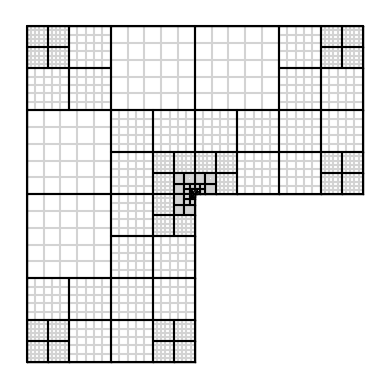

Residual contributions took 0.810197114944458 seconds.
Jump contributions took 1.516634464263916 seconds.
Refinement took 0.03649592399597168 seconds for 3 patches.
setting up constraints took 0.5376520156860352 seconds.
Basis setup took 0.052674293518066406 seconds
Prolongation took 0.022792577743530273 seconds
12


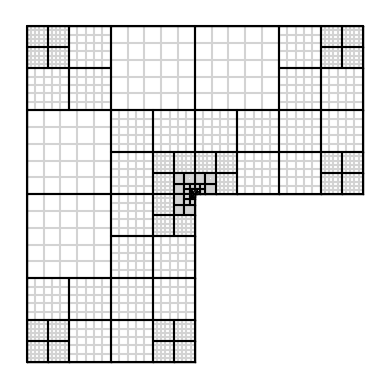

Residual contributions took 0.839092493057251 seconds.
Jump contributions took 1.6321699619293213 seconds.
Refinement took 0.038060665130615234 seconds for 3 patches.
setting up constraints took 0.5781974792480469 seconds.
Basis setup took 0.05942654609680176 seconds
Prolongation took 0.023578166961669922 seconds
13


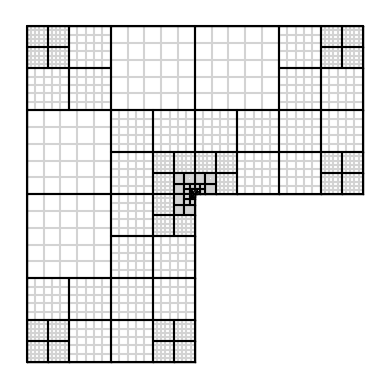

Residual contributions took 0.8997175693511963 seconds.
Jump contributions took 1.7290277481079102 seconds.
Refinement took 0.11119914054870605 seconds for 8 patches.
setting up constraints took 0.677239179611206 seconds.
Basis setup took 0.06586623191833496 seconds
Prolongation took 0.05839681625366211 seconds
14


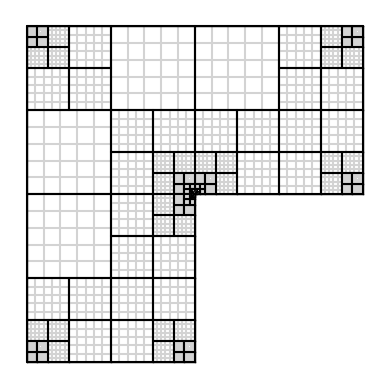

Residual contributions took 1.0527610778808594 seconds.
Jump contributions took 2.0114986896514893 seconds.
Refinement took 0.04565906524658203 seconds for 3 patches.
setting up constraints took 0.7145223617553711 seconds.
Basis setup took 0.0768589973449707 seconds
Prolongation took 0.024255990982055664 seconds
15


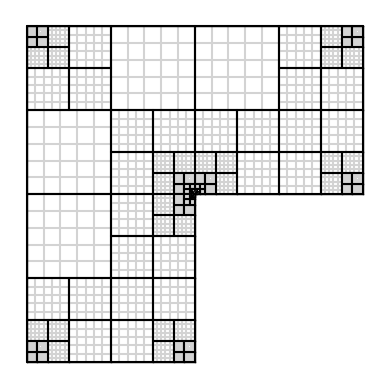

Residual contributions took 1.0951783657073975 seconds.
Jump contributions took 2.117366313934326 seconds.
Refinement took 0.04718732833862305 seconds for 3 patches.
setting up constraints took 0.7523336410522461 seconds.
Basis setup took 0.07324790954589844 seconds
Prolongation took 0.0228421688079834 seconds
16


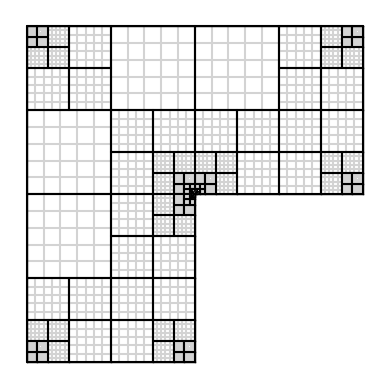

Residual contributions took 1.1814546585083008 seconds.
Jump contributions took 2.244394302368164 seconds.
Refinement took 0.13567662239074707 seconds for 8 patches.
setting up constraints took 0.860149621963501 seconds.
Basis setup took 0.08245468139648438 seconds
Prolongation took 0.05815458297729492 seconds
17


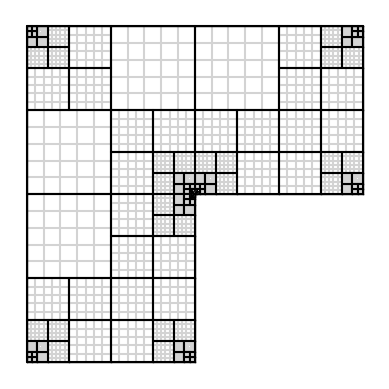

Residual contributions took 1.2977559566497803 seconds.
Jump contributions took 2.5099759101867676 seconds.
Refinement took 0.05470442771911621 seconds for 3 patches.
setting up constraints took 0.8984787464141846 seconds.
Basis setup took 0.08645510673522949 seconds
Prolongation took 0.02322244644165039 seconds
18


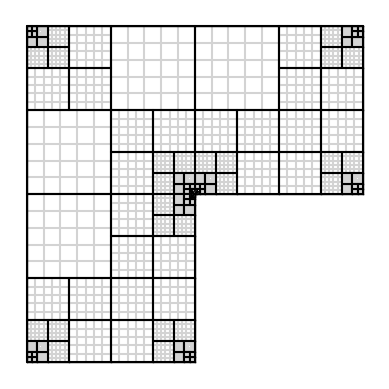

Residual contributions took 1.3603160381317139 seconds.
Jump contributions took 2.6145100593566895 seconds.
Refinement took 0.0562589168548584 seconds for 3 patches.
setting up constraints took 0.9417352676391602 seconds.
Basis setup took 0.09884142875671387 seconds
Prolongation took 0.024790525436401367 seconds
19


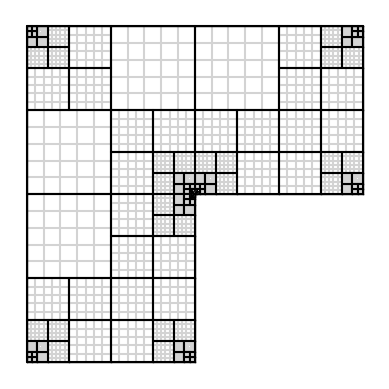

Residual contributions took 1.4091203212738037 seconds.
Jump contributions took 2.733905553817749 seconds.
Refinement took 0.16257715225219727 seconds for 8 patches.
setting up constraints took 1.0520756244659424 seconds.
Basis setup took 0.10964345932006836 seconds
Prolongation took 0.061309814453125 seconds
20


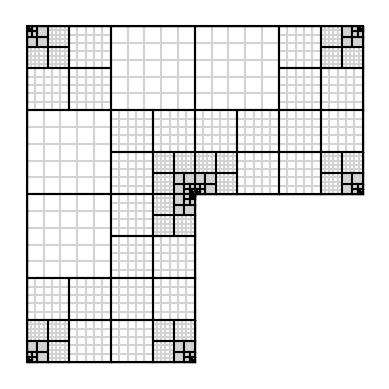

Residual contributions took 1.5832855701446533 seconds.
Jump contributions took 3.001648426055908 seconds.
Refinement took 0.06367230415344238 seconds for 3 patches.
setting up constraints took 1.0911686420440674 seconds.
Basis setup took 0.10637784004211426 seconds
Prolongation took 0.023616552352905273 seconds
21


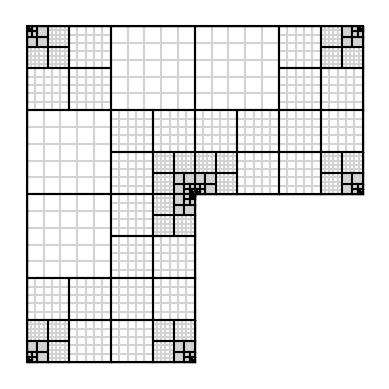

Residual contributions took 1.6155874729156494 seconds.
Jump contributions took 3.1249353885650635 seconds.
Refinement took 0.3281252384185791 seconds for 14 patches.
setting up constraints took 1.2652649879455566 seconds.
Basis setup took 0.11830401420593262 seconds
Prolongation took 0.10500979423522949 seconds
22


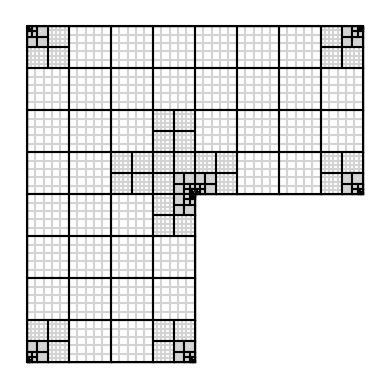

Residual contributions took 1.8787257671356201 seconds.
Jump contributions took 3.616708993911743 seconds.
Refinement took 0.1743922233581543 seconds for 7 patches.
setting up constraints took 1.3688983917236328 seconds.
Basis setup took 0.13758015632629395 seconds
Prolongation took 0.05529427528381348 seconds
23


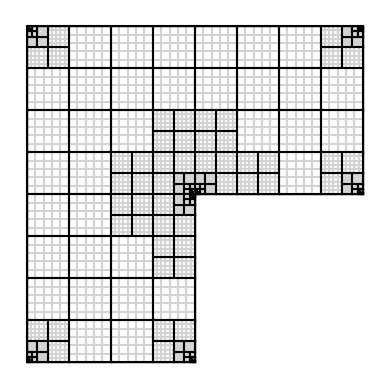

Residual contributions took 2.003188133239746 seconds.
Jump contributions took 3.847537040710449 seconds.
Refinement took 0.2938365936279297 seconds for 11 patches.
setting up constraints took 1.5323691368103027 seconds.
Basis setup took 0.16120648384094238 seconds
Prolongation took 0.08734464645385742 seconds
24


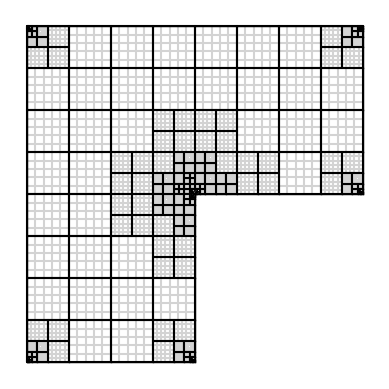

Residual contributions took 2.218045473098755 seconds.
Jump contributions took 4.294237375259399 seconds.
Refinement took 0.5359287261962891 seconds for 18 patches.
setting up constraints took 1.7941820621490479 seconds.
Basis setup took 0.19585299491882324 seconds
Prolongation took 0.142256498336792 seconds
25


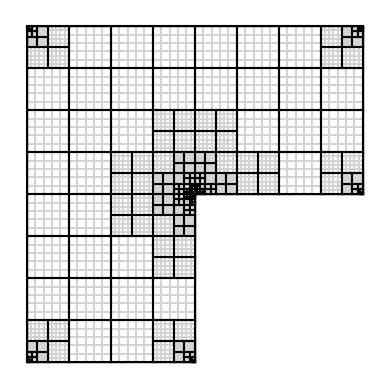

Residual contributions took 2.559285879135132 seconds.
Jump contributions took 4.857088565826416 seconds.
Refinement took 0.6195559501647949 seconds for 18 patches.
setting up constraints took 2.058253526687622 seconds.
Basis setup took 0.20362162590026855 seconds
Prolongation took 0.13585638999938965 seconds
26


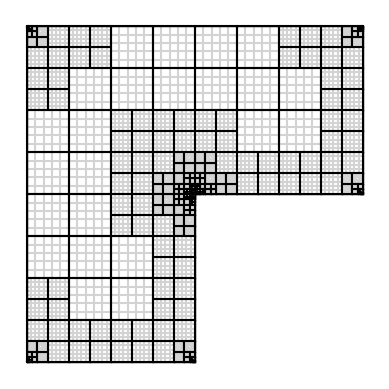

Residual contributions took 2.8632493019104004 seconds.
Jump contributions took 5.5132269859313965 seconds.
Refinement took 0.8475990295410156 seconds for 23 patches.
setting up constraints took 2.4233713150024414 seconds.
Basis setup took 0.24216461181640625 seconds
Prolongation took 0.17377758026123047 seconds
27


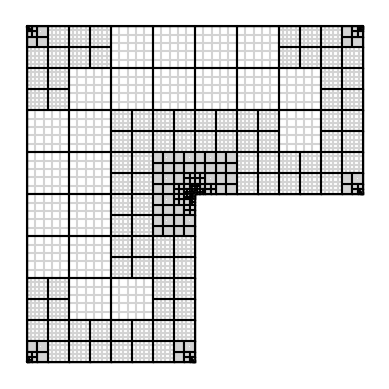

Residual contributions took 3.2787115573883057 seconds.
Jump contributions took 6.651907444000244 seconds.
Refinement took 1.4223606586456299 seconds for 33 patches.
setting up constraints took 2.9395179748535156 seconds.
Basis setup took 0.3337886333465576 seconds
Prolongation took 0.25694990158081055 seconds
28


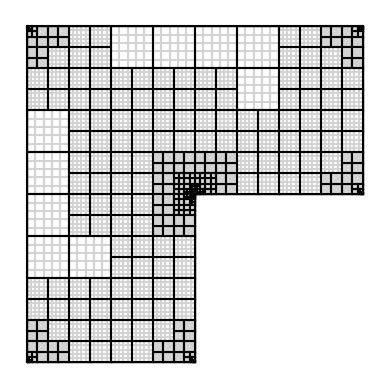

Residual contributions took 3.8981823921203613 seconds.
Jump contributions took 7.352712392807007 seconds.
Refinement took 1.133387565612793 seconds for 24 patches.
setting up constraints took 3.3399007320404053 seconds.
Basis setup took 0.4006922245025635 seconds
Prolongation took 0.18792366981506348 seconds
29


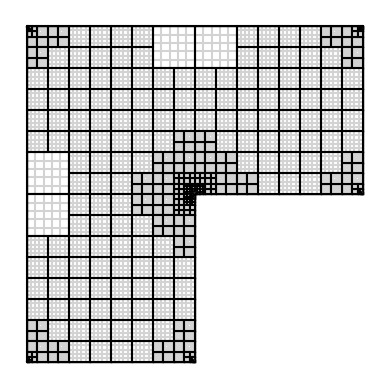

Residual contributions took 4.318897008895874 seconds.
Jump contributions took 8.123568773269653 seconds.
Refinement took 2.7809369564056396 seconds for 52 patches.
setting up constraints took 4.29330849647522 seconds.
Basis setup took 0.5032482147216797 seconds
Prolongation took 0.4035763740539551 seconds
30


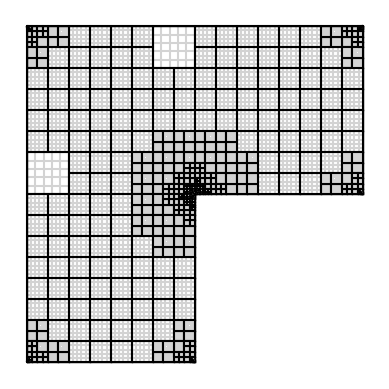

Residual contributions took 5.314602375030518 seconds.
Jump contributions took 10.034034967422485 seconds.
Refinement took 2.4151859283447266 seconds for 39 patches.
setting up constraints took 5.028475999832153 seconds.
Basis setup took 0.6186058521270752 seconds
Prolongation took 0.30680060386657715 seconds
31


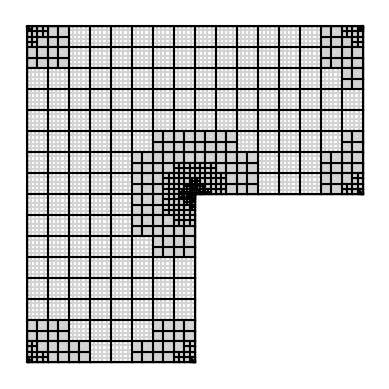

Residual contributions took 6.027546167373657 seconds.
Jump contributions took 11.240401983261108 seconds.
Refinement took 3.4448840618133545 seconds for 50 patches.
setting up constraints took 5.98565673828125 seconds.
Basis setup took 0.7246158123016357 seconds
Prolongation took 0.3988504409790039 seconds
32


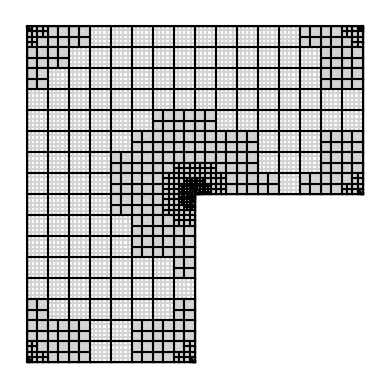

Residual contributions took 6.9764933586120605 seconds.
Jump contributions took 13.007362127304077 seconds.
Refinement took 6.396301507949829 seconds for 80 patches.
setting up constraints took 7.770827531814575 seconds.
Basis setup took 1.0204036235809326 seconds
Prolongation took 0.6457622051239014 seconds
33


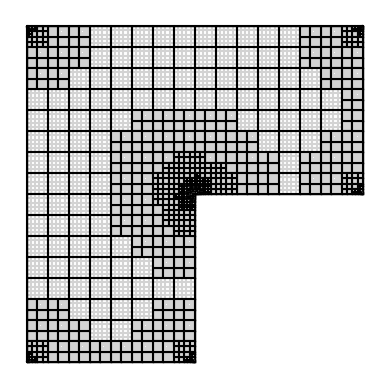

Residual contributions took 8.410918235778809 seconds.
Jump contributions took 15.677835702896118 seconds.
Refinement took 8.160107851028442 seconds for 87 patches.
setting up constraints took 9.786046028137207 seconds.
Basis setup took 1.5112595558166504 seconds
Prolongation took 0.7082185745239258 seconds
34


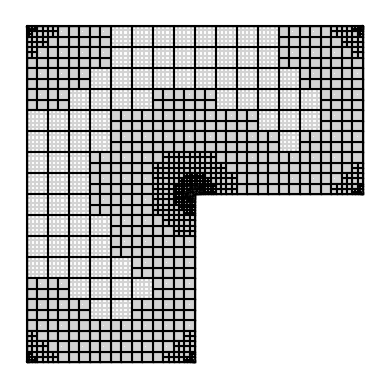

Residual contributions took 9.981018543243408 seconds.
Jump contributions took 18.612059593200684 seconds.
Refinement took 12.89534306526184 seconds for 117 patches.
setting up constraints took 12.656347513198853 seconds.
Basis setup took 1.8933591842651367 seconds
Prolongation took 0.9646942615509033 seconds
35


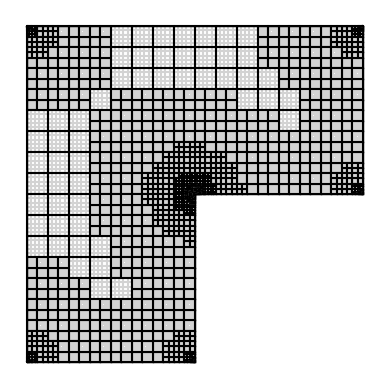

Residual contributions took 12.221937894821167 seconds.
Jump contributions took 22.535024881362915 seconds.
Refinement took 15.826462268829346 seconds for 122 patches.
setting up constraints took 16.25281548500061 seconds.
Basis setup took 2.511569023132324 seconds
Prolongation took 1.0286121368408203 seconds
36


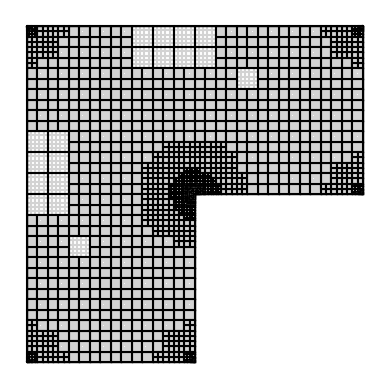

Residual contributions took 14.453104496002197 seconds.
Jump contributions took 26.6597261428833 seconds.
Refinement took 21.767622709274292 seconds for 144 patches.
setting up constraints took 20.409669399261475 seconds.
Basis setup took 3.731187105178833 seconds
Prolongation took 1.241931438446045 seconds
37


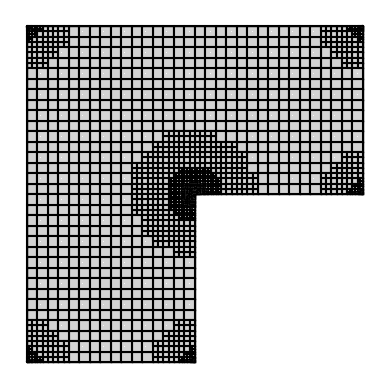

Residual contributions took 17.158127307891846 seconds.
Jump contributions took 32.057655811309814 seconds.
Refinement took 32.237014055252075 seconds for 182 patches.
setting up constraints took 28.061923027038574 seconds.
Basis setup took 5.107324600219727 seconds
Prolongation took 1.61503267288208 seconds
38


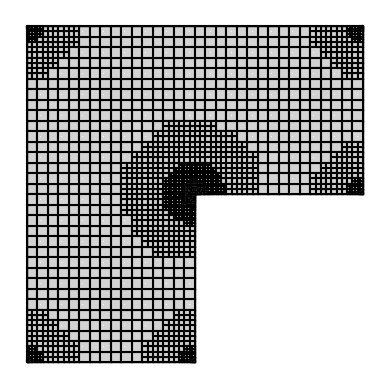

Residual contributions took 20.608824729919434 seconds.
Jump contributions took 37.76814651489258 seconds.
Refinement took 54.88738822937012 seconds for 249 patches.
setting up constraints took 41.01608872413635 seconds.
Basis setup took 6.606155872344971 seconds
Prolongation took 2.2533154487609863 seconds
39


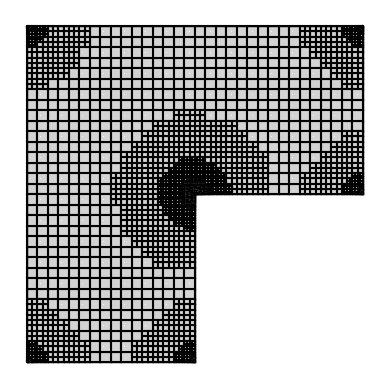

Residual contributions took 25.25072956085205 seconds.
Jump contributions took 46.0953414440155 seconds.
Refinement took 84.98226141929626 seconds for 319 patches.
setting up constraints took 61.96378135681152 seconds.
Basis setup took 10.333229303359985 seconds
Prolongation took 3.1028316020965576 seconds
40


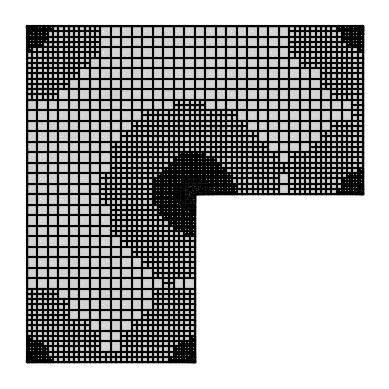

setting up constraints took 140.16914463043213 seconds.
Basis setup took 25.580029487609863 seconds
41


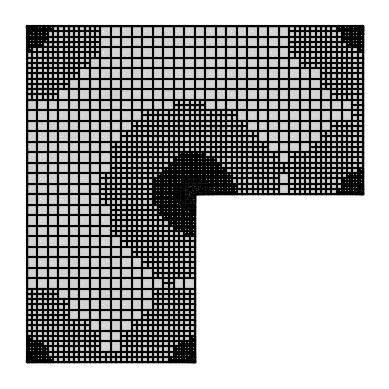

In [8]:
#23,28,42
for deg, maxiter in zip((4,),(42,)):
    M_a = Lshape(deg,deg+1)
    MP_a = assemble.Multipatch(M_a, automatch=True)
    uh_a=[]
    P_a=[]
    err_ind=[]

    numdofs_a =np.zeros(maxiter)
    err_est=np.zeros(maxiter)

    for i in range(maxiter):
        print(i)
        MP_a.mesh.draw(bwidth=1, knots=1, axis='off')
        plt.axis('scaled');
        plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'corner/i'+str(i)+'.png',bbox_inches='tight');
        plt.show()
        numdofs_a[i]=MP_a.numdofs
        bcs = MP_a.compute_dirichlet_bcs({0:0.})
        Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
        Mh_a = MP_a.assemble_volume(vform.mass_vf(2))
        F_a = MP_a.assemble_volume(vform.L2functional_vf(2, physical=True), f=lambda x,y: 1.)
        LS = assemble.RestrictedLinearSystem(Kh_a, F_a, bcs)
        uh_a.append(LS.complete((cholesky(LS.A))(LS.b)))

        if i < maxiter-2 :
            err_ind.append(adap.mp_resPois(MP_a,uh_a[i],f={0:lambda x,y: 1.}))
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_mark(err_ind[-1], 0.9)
            marked_patches = {p:None for p in marked_patches}
            P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
            #MP_a.mesh.draw(plt.figure())
        elif i == maxiter-2:
            P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
        else:
            pass

    for k in reversed(range(1,len(P_a))):
        P_a[k-1]=P_a[k]@P_a[k-1]

    L2err_a = np.zeros(maxiter)
    H1err_a = np.zeros(maxiter)
    for i in range(len(uh_a)-1):
        eh = P_a[i]@uh_a[i]-uh_a[-1]
        L2err_a[i] = eh @ Mh_a @ eh
        H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
    L2err_a = sqrt(np.array(L2err_a))
    H1err_a = sqrt(np.array(H1err_a))
    np.savetxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'corner.txt',np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

In [111]:
np.savetxt('Lp'+str(deg)+'n'+str(deg+1)+'corner.txt', np.c_[[numdofs_a,H1err_a,L2err_a,err_est]])

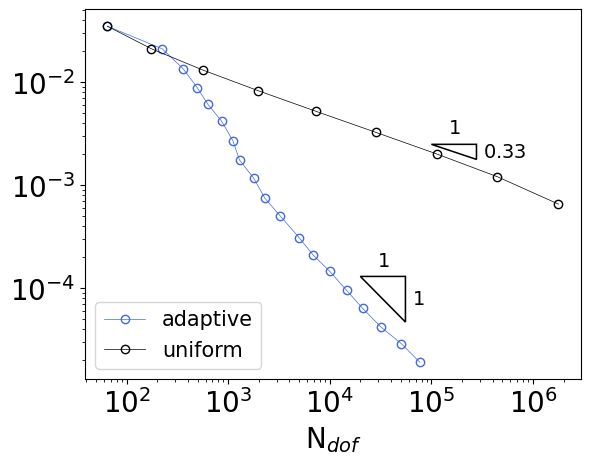

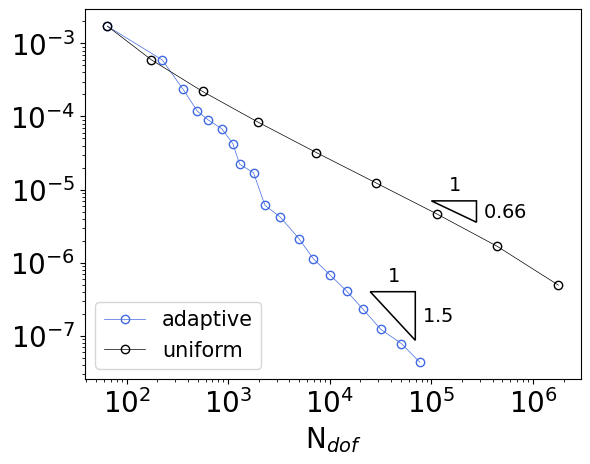

In [34]:
deg=2
numdofs,H1err,L2err=np.loadtxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'corner_uni.txt').reshape((3,-1))
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'corner.txt').reshape((4,-1))

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptive','uniform','error estimator'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$",size=20)
draw_loglog_slope(fig,ax,(2*1e4,1.3*1e-4),2, int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1e5,2.5*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# ax.set_xlim([1e1,1e5]);
# ax.set_ylim([1e-8,0.3]);
#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'corner/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], '^-',color='red',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[16:22],[0.001/n**(1) for n in numdofs_a[16:22]],linestyle='--')
#plt.loglog(numdofs[3:6],[0.2/n**(2/3) for n in numdofs[3:6]],linestyle='--')
plt.legend(['adaptive','uniform'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$",size=20)
draw_loglog_slope(fig,ax,(2.5*1e4,4*1e-7),2,slope=(deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1e5,7*1e-6),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#axis('scaled');
plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'corner/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

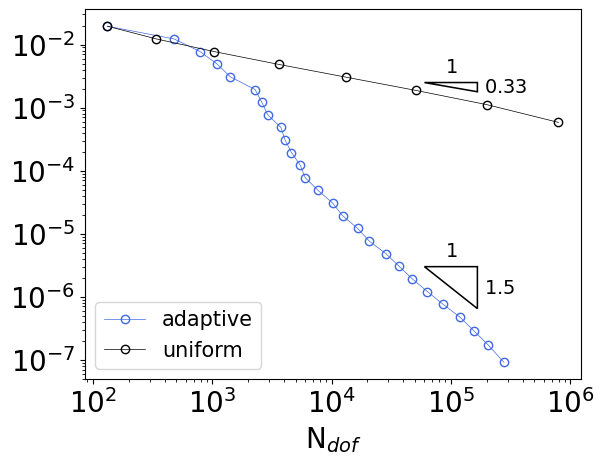

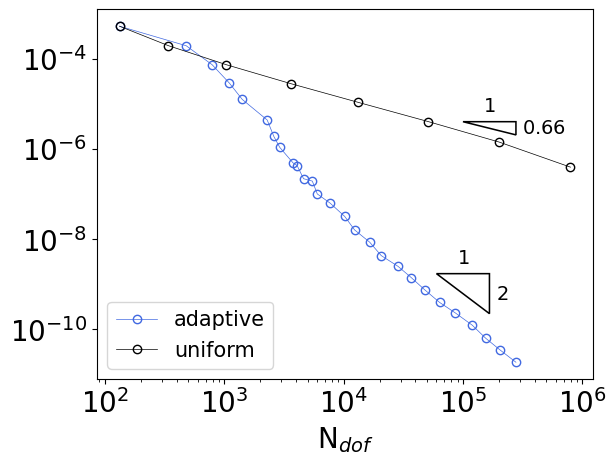

In [58]:
deg=3
numdofs,H1err,L2err=np.loadtxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'corner_uni.txt').reshape((3,-1))
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'corner.txt').reshape((4,-1))
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-2], err_est[:-2], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptive','uniform'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$", size=20)

draw_loglog_slope(fig,ax,(6*1e4,3*1e-6),2,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(6*1e4,2.5*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'corner/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptive','uniform'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$", size=20)

draw_loglog_slope(fig,ax,(6*1e4,1.7*1e-9),2,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(1e5,4*1e-6),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'corner/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

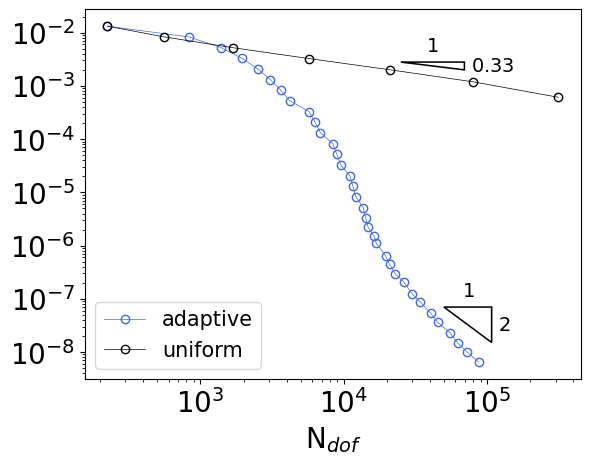

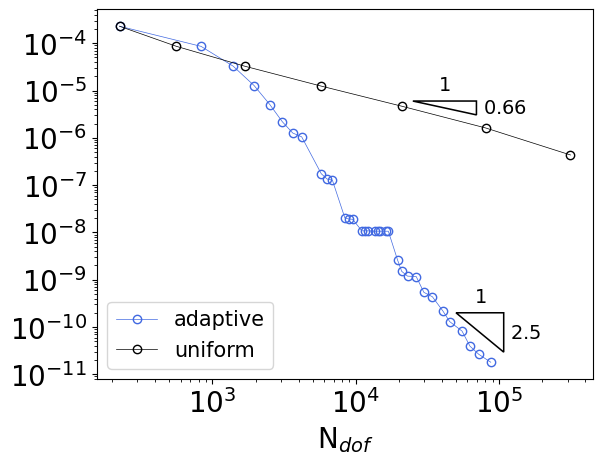

In [59]:
deg=4
numdofs,H1err,L2err=np.loadtxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'corner_uni.txt').reshape((3,-1))
numdofs_a,H1err_a,L2err_a,err_est=np.loadtxt('/home/wolfman/Documents/L-shape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'corner.txt').reshape((4,-1))
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-2], err_est[:-2], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptive','uniform'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$",size=20)

draw_loglog_slope(fig,ax,(5*1e4,7*1e-8),1.5,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)
draw_loglog_slope(fig,ax,(2.5*1e4,2.8*1e-3),2,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'corner/Lp'+str(deg)+'n'+str(deg+1)+'H1_cnv.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptive','uniform'],loc='lower left',prop={'size': 15})
plt.xlabel("N$_{dof}$", size=20)

draw_loglog_slope(fig,ax,(5*1e4,2*1e-10),1.5,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', label_kwargs={'fontsize':14}, label=True, labelcolor=None, zorder=None)
draw_loglog_slope(fig,ax,(2.5*1e4,6*1e-6),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs={'fontsize':14}, zorder=None)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'corner/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv.pdf', bbox_inches='tight')
plt.show()

In [69]:
MP_a.mesh.sanity_check()

In [18]:
numdofs_anp.loadtxt("Lp2n3corner.txt")

array([[6.50000e+01, 2.25000e+02, 3.61000e+02, 4.97000e+02, 6.33000e+02, 7.69000e+02, 1.05700e+03, 1.29700e+03, 1.57700e+03, 1.91300e+03, 2.39300e+03, 3.28900e+03, 4.81300e+03, 6.53700e+03, 9.18100e+03, 1.35850e+04, 2.01250e+04, 2.90850e+04, 4.53090e+04, 6.53530e+04, 9.14850e+04, 1.32897e+05, 4.13190e+05],
       [3.51651e-02, 2.11847e-02, 1.35584e-02, 8.88794e-03, 6.11681e-03, 4.57350e-03, 3.02554e-03, 1.75417e-03, 1.31609e-03, 9.92742e-04, 6.36479e-04, 4.89813e-04, 2.69567e-04, 1.92576e-04, 1.42996e-04, 1.01102e-04, 6.57483e-05, 4.21210e-05, 2.89791e-05, 2.02736e-05, 1.45067e-05, 9.90804e-06, 0.00000e+00],
       [1.71948e-03, 5.93418e-04, 2.34674e-04, 1.18466e-04, 9.02741e-05, 8.53600e-05, 5.61973e-05, 2.22410e-05, 2.07724e-05, 1.69656e-05, 6.24517e-06, 5.18396e-06, 2.12525e-06, 1.20125e-06, 7.79346e-07, 5.31264e-07, 3.01402e-07, 1.32722e-07, 8.30550e-08, 4.99678e-08, 3.21995e-08, 1.73289e-08, 0.00000e+00],
       [5.73581e-02, 3.59820e-02, 2.28712e-02, 1.47288e-02, 9.77259e-03, 6.8

In [49]:
del err_ind

In [51]:
del uh_a_